In [1]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from typing import List
from transform import TimeSeriesTransform
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [3]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [4]:
load = '20kg'
filenames_20kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_20kg = [filename for sublist in filenames_20kg for filename in sublist]

load = '40kg'
filenames_40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_40kg = [filename for sublist in filenames_40kg for filename in sublist]

load = '-40kg'
filenames_m40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_m40kg = [filename for sublist in filenames_m40kg for filename in sublist]

In [5]:
def get_X_y(filenames, load, is_train=True):
    X, y = [], []
    data_dir = INSTANCES_DIR if is_train else INFERENCE_DIR
    for filename in filenames:
        load_num = load[:-2]
        state = re.match(fr'(.*)_{load_num}', filename).group(1)
        df = pd.read_csv(os.path.join(data_dir, load, state, filename))
        tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
        # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
        X.append(tmp_cur)
        y.append(state)
    return np.array(X), np.array(y)

In [6]:
X_20kg, y_20kg = get_X_y(filenames_20kg, load='20kg')
X_40kg, y_40kg = get_X_y(filenames_40kg, load='40kg')
X_m40kg, y_m40kg = get_X_y(filenames_m40kg, load='-40kg')

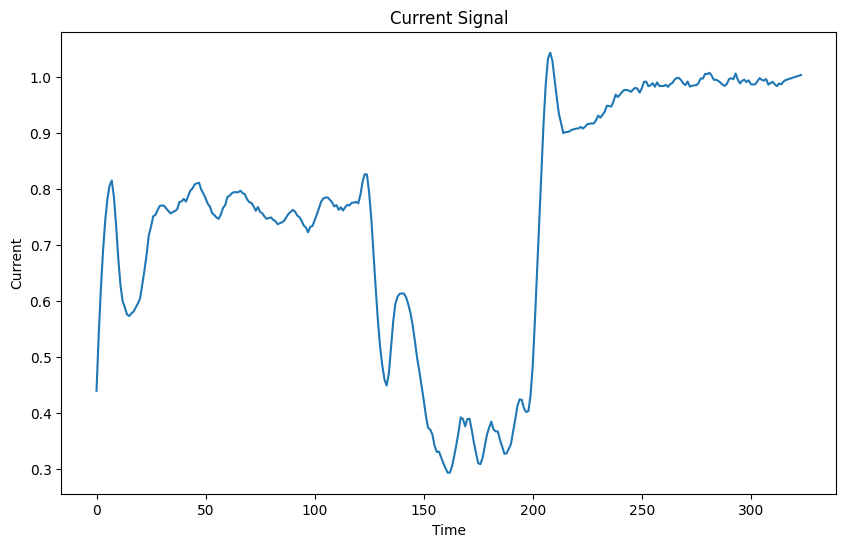

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Signal')
plt.show()

In [8]:
minmax_X_20kg = 2 * (X_20kg - np.min(X_20kg, axis=1, keepdims=True)) / (np.max(X_20kg, axis=1, keepdims=True) - np.min(X_20kg, axis=1, keepdims=True)) - 1
minmax_X_40kg = 2 * (X_40kg - np.min(X_40kg, axis=1, keepdims=True)) / (np.max(X_40kg, axis=1, keepdims=True) - np.min(X_40kg, axis=1, keepdims=True)) - 1
minmax_X_m40kg = 2 * (X_m40kg - np.min(X_m40kg, axis=1, keepdims=True)) / (np.max(X_m40kg, axis=1, keepdims=True) - np.min(X_m40kg, axis=1, keepdims=True)) - 1

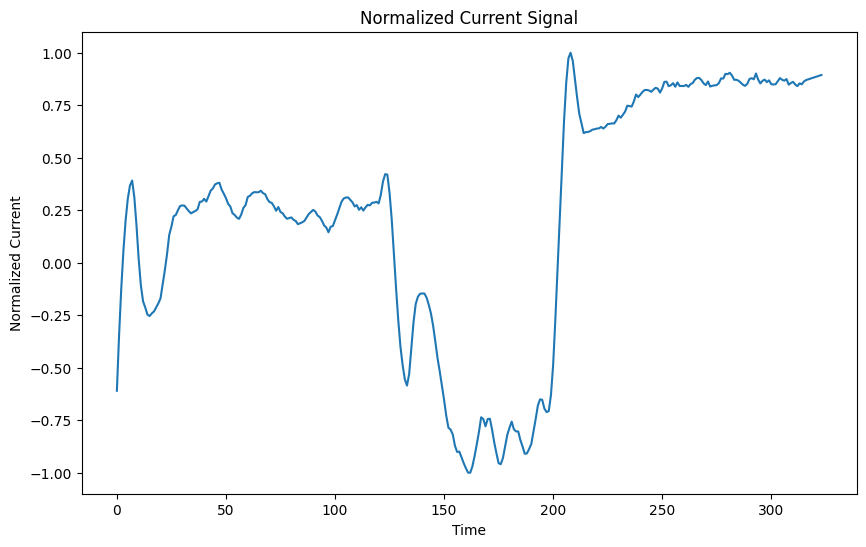

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(minmax_X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Normalized Current')
plt.title('Normalized Current Signal')
plt.show()

In [10]:
lower_bound = 1   # Lower bound of the range (inclusive)
upper_bound = 200 # Upper bound of the range (exclusive)
n_kernels = 1000
np.random.seed(42)  # for reproducibility
random_scales = np.random.uniform(lower_bound, upper_bound, n_kernels)
wavelet = 'morl' 

In [11]:
def simpsons_integral(x, y):
    """
    Approximates the integral of a function given by data points (x, y) using Simpson's rule.

    Parameters:
        x (array-like): Array of x values (must be evenly spaced).
        y (array-like): Array of y values corresponding to f(x) at each x.

    Returns:
        float: Approximate integral of the function.
    """
    # Ensure an even number of intervals
    if (len(x) - 1) % 2 != 0:
        x = x[:-1]
        y = y[:-1]

    n = len(x) - 1
    h = (x[-1] - x[0]) / n
    
    # Apply Simpson's rule formula
    integral = y[0] + y[-1] + 4 * np.sum(y[1:-1:2]) + 2 * np.sum(y[2:-2:2])
    integral *= h / 3
    return integral

In [12]:
coefficients, freqs = pywt.cwt(minmax_X_20kg[0], random_scales, wavelet, method='conv')
coefficients.shape

(1000, 324)

In [13]:
x_arr = np.arange(0, len(coefficients[0]))
x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
x_arr.shape

(1000, 324)

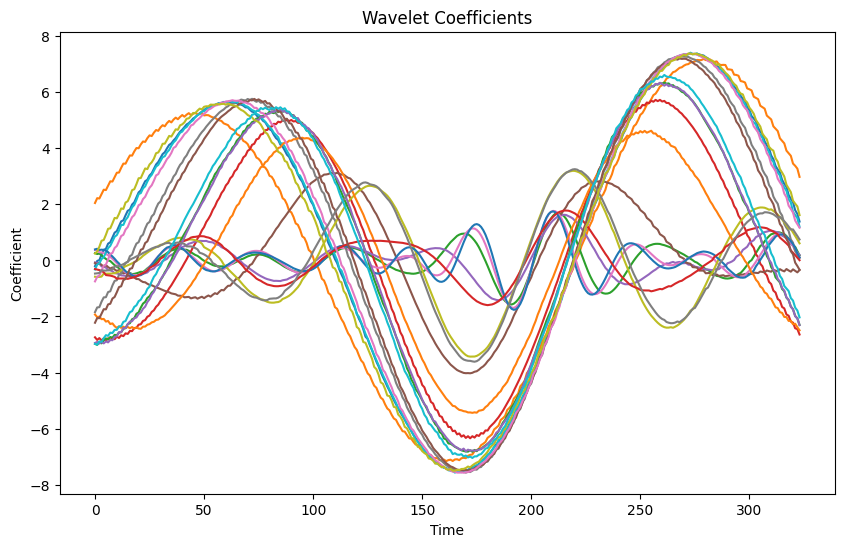

In [14]:
plt.figure(figsize=(10, 6))

for _ in range(20):
    rand_idx = np.random.randint(coefficients.shape[0])
    plt.plot(x_arr[0], coefficients[rand_idx])

plt.xlabel('Time')
plt.ylabel('Coefficient')
plt.title('Wavelet Coefficients')
plt.show()

In [15]:
res = np.array([simpsons_integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
print(f'After integral: {res.shape}')

After integral: (1000,)


In [16]:
def raven(sample, random_scales, wavelet, integral):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, method='conv')
    x_arr = np.arange(0, len(coefficients[0]))
    x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
    integral = np.array([integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
    return integral

def raven_parallel(X, random_scales, wavelet, integral, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven, X[i], random_scales, wavelet, integral) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [17]:
raven_results_20kg_p = raven_parallel(minmax_X_20kg, random_scales, wavelet, simpsons_integral)
raven_results_20kg_np = np.array(raven_results_20kg_p)

100%|██████████| 374/374 [00:22<00:00, 16.30it/s]


In [18]:
ridge_20 = RidgeClassifierCV()
lda_20 = LDA()
ridge_20.fit(raven_results_20kg_np, y_20kg)
lda_20.fit(raven_results_20kg_np, y_20kg)
print(f'20kg Ridge: {ridge_20.score(raven_results_20kg_p, y_20kg)}')
print(f'20kg LDA: {lda_20.score(raven_results_20kg_p, y_20kg)}')

20kg Ridge: 0.7379679144385026
20kg LDA: 1.0


In [19]:
raven_results_40kg_p = raven_parallel(minmax_X_40kg, random_scales, wavelet, simpsons_integral)
raven_results_40kg_np = np.array(raven_results_40kg_p)

  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [00:21<00:00, 16.34it/s]


In [20]:
ridge_40 = RidgeClassifierCV()
lda_40 = LDA()

ridge_40.fit(raven_results_40kg_np, y_40kg)
lda_40.fit(raven_results_40kg_np, y_40kg)
print(f'Ridge 40kg: {ridge_40.score(raven_results_40kg_np, y_40kg)}')
print(f'LDA 40kg: {lda_40.score(raven_results_40kg_np, y_40kg)}')

Ridge 40kg: 0.9888268156424581
LDA 40kg: 1.0


In [21]:
raven_results_m40kg_p = raven_parallel(minmax_X_m40kg, random_scales, wavelet, simpsons_integral)
raven_results_m40kg_np = np.array(raven_results_m40kg_p)

100%|██████████| 367/367 [00:23<00:00, 15.87it/s]


In [22]:
ridge_m40 = RidgeClassifierCV()
lda_m40 = LDA()

ridge_m40.fit(raven_results_m40kg_np, y_m40kg)
lda_m40.fit(raven_results_m40kg_np, y_m40kg)

print(f'-40kg: {ridge_m40.score(raven_results_m40kg_np, y_m40kg)}')
print(f'-40kg: {lda_m40.score(raven_results_m40kg_np, y_m40kg)}')

-40kg: 0.8719346049046321
-40kg: 1.0


In [23]:
load = '20kg'
filenames_20kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_20kg_t = [filename for sublist in filenames_20kg_t for filename in sublist]

load = '40kg'
filenames_40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_40kg_t = [filename for sublist in filenames_40kg_t for filename in sublist]

load = '-40kg'
filenames_m40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_m40kg_t = [filename for sublist in filenames_m40kg_t for filename in sublist]

In [24]:
X_20kg_t, y_20kg_t = get_X_y(filenames_20kg_t, load='20kg', is_train=False)
X_40kg_t, y_40kg_t = get_X_y(filenames_40kg_t, load='40kg', is_train=False)
X_m40kg_t, y_m40kg_t = get_X_y(filenames_m40kg_t, load='-40kg', is_train=False)

In [25]:
minmax_X_20kg_t = 2 * (X_20kg_t - np.min(X_20kg_t, axis=1, keepdims=True)) / (np.max(X_20kg_t, axis=1, keepdims=True) - np.min(X_20kg_t, axis=1, keepdims=True)) - 1
minmax_X_40kg_t = 2 * (X_40kg_t - np.min(X_40kg_t, axis=1, keepdims=True)) / (np.max(X_40kg_t, axis=1, keepdims=True) - np.min(X_40kg_t, axis=1, keepdims=True)) - 1
minmax_X_m40kg_t = 2 * (X_m40kg_t - np.min(X_m40kg_t, axis=1, keepdims=True)) / (np.max(X_m40kg_t, axis=1, keepdims=True) - np.min(X_m40kg_t, axis=1, keepdims=True)) - 1

In [26]:
raven_results_20kg_t = raven_parallel(minmax_X_20kg_t, random_scales, wavelet, simpsons_integral)
raven_results_20kg_t_np = np.array(raven_results_20kg_t)

100%|██████████| 130/130 [00:08<00:00, 15.73it/s]


In [28]:
print(f'20kg Ridge Test: {ridge_20.score(raven_results_20kg_t_np, y_20kg_t)}')
print(f'20kg LDA Test: {lda_20.score(raven_results_20kg_t_np, y_20kg_t)}')

20kg Ridge Test: 0.5461538461538461
20kg LDA Test: 0.6384615384615384


In [29]:
raven_results_40kg_t = raven_parallel(minmax_X_40kg_t, random_scales, wavelet, simpsons_integral)
raven_results_40kg_t_np = np.array(raven_results_40kg_t)

100%|██████████| 129/129 [00:07<00:00, 16.13it/s]


In [30]:
print(f'40kg Ridge Test: {ridge_40.score(raven_results_40kg_t_np, y_40kg_t)}')
print(f'40kg LDA Test: {lda_40.score(raven_results_40kg_t_np, y_40kg_t)}')

40kg Ridge Test: 0.6124031007751938
40kg LDA Test: 0.6511627906976745


In [31]:
raven_results_m40kg_t = raven_parallel(minmax_X_m40kg_t, random_scales, wavelet, simpsons_integral)
raven_results_m40kg_t_np = np.array(raven_results_m40kg_t)

100%|██████████| 130/130 [00:08<00:00, 15.98it/s]


In [32]:
print(f'm40kg Ridge Test: {ridge_m40.score(raven_results_m40kg_t_np, y_m40kg_t)}')
print(f'm40kg LDA Test: {lda_m40.score(raven_results_m40kg_t_np, y_m40kg_t)}')

m40kg Ridge Test: 0.5692307692307692
m40kg LDA Test: 0.7461538461538462


## Use ROCKET for Comparison

In [33]:
from pyts.transformation import ROCKET

rocket = ROCKET(random_state=0)

rocket.fit(X_20kg)

rocket_results_20kg = rocket.transform(X_20kg)
rocket_results_20kg_t = rocket.transform(X_20kg_t)
rocket_20 = RidgeClassifierCV()
rocket_20.fit(rocket_results_20kg, y_20kg)
print(f'20kg train: {rocket_20.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test: {rocket_20.score(rocket_results_20kg_t, y_20kg_t)}')

20kg train: 0.9973262032085561
20kg test: 0.7307692307692307


In [34]:
rocket.fit(X_40kg)

rocket_results_40kg = rocket.transform(X_40kg)
rocket_results_40kg_t = rocket.transform(X_40kg_t)
rocket_40 = RidgeClassifierCV()
rocket_40.fit(rocket_results_40kg, y_40kg)
print(f'40kg train: {rocket_40.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test: {rocket_40.score(rocket_results_40kg_t, y_40kg_t)}')

40kg train: 1.0
40kg test: 0.7209302325581395


In [35]:
rocket.fit(X_m40kg)

rocket_results_m40kg = rocket.transform(X_m40kg)
rocket_results_m40kg_t = rocket.transform(X_m40kg_t)
rocket_m40 = RidgeClassifierCV()
rocket_m40.fit(rocket_results_m40kg, y_m40kg)
print(f'm40kg train: {rocket_m40.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test: {rocket_m40.score(rocket_results_m40kg_t, y_m40kg_t)}')

m40kg train: 1.0
-40kg test: 0.7615384615384615
